In [ ]:
!pip install -q "tmtoolkit[recommended]"

In [ ]:
import re
import numpy as np
import gzip
import json
from collections import defaultdict
from tmtoolkit.corpus import Corpus, print_summary, dtm
from tmtoolkit.corpus import remove_common_tokens, remove_uncommon_tokens
import spacy
import networkx as nx
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

WORKING_DIR = 'drive/MyDrive/dtsa5800_tweets_network_analysis'
DATA_DIR = f'{WORKING_DIR}/data'
DATA_FILE = f'{DATA_DIR}/nikelululemonadidas_tweets.jsonl.gz'


## Semantic Network Graph

In [ ]:
brands = ['nike', 'adidas', 'lululemon']
tweets = {}

with gzip.open(DATA_FILE, 'r') as f:
    for line in f:
        tweet = json.loads(line)
        tweet_id = tweet.get('id', None)
        if tweet_id is None:
            continue
        text = tweet.get('full_text') or tweet.get('text', '')
        if any(brand in text.lower() for brand in brands):
            tweets[str(tweet_id)] = text

print(len(tweets))

163285


In [ ]:
for i, (id, text) in enumerate(tweets.items()):
    if i < 5:
        print(f'{i} - {id} - {text}')


0 - 1443854459625431000 - #ad The Nike Women's Air More Uptempo 96 'White/Opti Yellow' is now available via @footlocker! |$160| #SneakerScouts @Nike https://t.co/5lAq7b2ffU https://t.co/wmjxIcsheP
1 - 1443842433641558000 - @_christiankeith @d1vetsam @KicksFinder They are available too at @adidas
2 - 1443878848211439600 - Proof @LaserShip is stealing. I work from home and have a ring doorbell. @wsoctv @Nike @wcnc @wbtv @bbb_us https://t.co/9o3stezjgs
3 - 1443843563108905000 - RT @pyleaks: *LEAK ALERT*: The next Supreme x @Nike collab for Spring 2022 will feature the Nike Shox Ride 2.
The duo will be dropping 3 co…
4 - 1443823529296867300 - RT @SneakerScouts: #ad The Space Jam x Nike LeBron 18 Low 'Sylvester vs. Tweety' is now available via @snipes_usa! |$160| #SneakerScouts @K…


In [ ]:
def build_corpus(text_dict, add_stopwords=None, remove_mentions=False, remove_hashtags=False, min_length=3, lang='en'):
    nlp = spacy.load(f"{lang}_core_web_sm")
    if add_stopwords:
        nlp.Defaults.stop_words.update(set(add_stopwords))

    cleaned_dict = {}
    for key, text in text_dict.items():
        doc = nlp(text.lower())

        lemmas = []
        for token in doc:
            if token.like_url:
                continue
            t = token.text
            if remove_mentions and t.startswith('@'):
                continue
            if remove_hashtags and t.startswith('#'):
                continue
            sub_tokens = re.findall(r'[a-zA-Z]+', t)
            for sub_token in sub_tokens:
                if sub_token in brands:
                    lemmas.append(sub_token)
                else:
                    lemma = nlp(sub_token)[0].lemma_
                    if len(lemma) >= min_length:
                        lemmas.append(lemma)

        final_lemmas = [lemma for lemma in lemmas if lemma not in nlp.Defaults.stop_words]
        cleaned_dict[key] = ' '.join(final_lemmas)

    corpus = Corpus(cleaned_dict, language=lang)
    remove_common_tokens(corpus, df_threshold=0.88)
    remove_uncommon_tokens(corpus, df_threshold=0.0003)
    print_summary(corpus)

    return corpus


In [ ]:
def build_graph(corpus, num_top_terms=None):
    dtm_mat, vocab = dtm(corpus, return_vocab=True)

    if num_top_terms:
        num_top_terms = min(num_top_terms, len(vocab))
        dfreq = dtm_mat.sum(axis=0)
        dfreq_array = np.ravel(dfreq)
        top_indices = np.argsort(-dfreq_array)[:num_top_terms]
        top_terms = [vocab[i] for i in top_indices]
        print(top_terms)
        filtered_dtm = dtm_mat[:, top_indices]
        coocc_mat = filtered_dtm.T.dot(filtered_dtm)
        target_vocab = top_terms
    else:
        coocc_mat = dtm_mat.T.dot(dtm_mat)
        target_vocab = vocab

    graph = nx.Graph()
    for i, term1 in enumerate(target_vocab):
        for j, term2 in enumerate(target_vocab):
            if i < j and coocc_mat[i, j] > 0:
                graph.add_edge(term1, term2, weight=coocc_mat[i, j])

    nodes = graph.number_of_nodes()
    edges = graph.number_of_edges()
    print(f"Graph has {nodes} nodes and {edges} edges.")
    return graph


In [ ]:
def draw_network_graph(graph, figsize=(25, 20), node_size=800):
    pos = nx.spring_layout(graph, k=2, iterations=20)
    plt.figure(figsize=figsize)
    nx.draw_networkx(graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=node_size, width=1)
    plt.show()

In [ ]:
sws = ['amp', 'away', 'come', 'day', 'dear', 'help', 'hey', 'include', 'know', 'let', 'lol', 'look', 'maybe', 'nft', 'shit',
       'snkr', 'start', 'stop', 'thee', 'think', 'time', 'today', 'use', 'want', 'way', 'welcome', 'week', 'year', 'https']


### Network 1
- Remove url
- keep only letters
- lemmatize
- remove stopwords
- filter by threshold
- select top 100 terms

In [ ]:
corp1 = build_corpus(tweets, sws)

Corpus with 163285 documents in English
> 1443819633753018400 (10 tokens): gomez brilliant nike cool build dogecoin airmax sh...
> 1443823529296867300 (9 tokens): sneakerscout space nike lebron low available snipe...
> 1443818860503834600 (12 tokens): sneakerscout nike air vapormax evo white wolf grey...
> 1443818136801849300 (6 tokens): surprise lot offwht nike wait dress
> 1443820484865536000 (12 tokens): nike air vapormax evo summit white bright crimson ...
> 1443822263552389000 (12 tokens): sneakerscout nike air max premium deep magenta aqu...
> 1443823065066922000 (7 tokens): kaya alexander nikestore nike sneakeradmiral aweso...
> 1443823277730902000 (7 tokens): niaonair simple black white episode nike comethru
> 1443820600326164500 (10 tokens): sftwofive chessncheck nike jumpman sneakeradmiral ...
> 1443823582702940200 (10 tokens): sneakerscout nike air max japan available snipe us...
(and 163275 more documents)
total number of tokens: 1251132 / vocabulary size: 2818


In [ ]:
graph1 = build_graph(corp1, 100)

['nike', 'adidas', 'xbox', 'sneakerscout', 'eneskanter', 'available', 'air', 'china', 'kingjame', 'try', 'win', 'nikestore', 'jumpman', 'austinekeler', 'book', 'knight', 'phil', 'fly', 'owner', 'ticket', 'follow', 'adidasfballu', 'finishline', 'plane', 'xboxsweepstake', 'chance', 'kit', 'exclusive', 'lululemon', 'icon', 'like', 'woman', 'shoe', 'new', 'max', 'usa', 'thank', 'theestallion', 'rtfktstudio', 'yardrunner', 'officially', 'slavery', 'graduation', 'good', 'modern', 'enduyghurforcedlabor', 'hypocritenike', 'love', 'need', 'nba', 'sneakeradmiral', 'game', 'snipe', 'buy', 'pair', 'black', 'white', 'brand', 'twitr', 'vapormax', 'force', 'sneaker', 'wear', 'right', 'adidasoriginal', 'people', 'app', 'lebron', 'news', 'run', 'drop', 'release', 'man', 'work', 'inspire', 'great', 'team', 'company', 'footlocker', 'metaverse', 'big', 'lasership', 'pass', 'flyknit', 'pack', 'jordan', 'labor', 'order', 'send', 'grey', 'sell', 'family', 'feel', 'low', 'virgil', 'dunk', 'abloh', 'slave', 'h

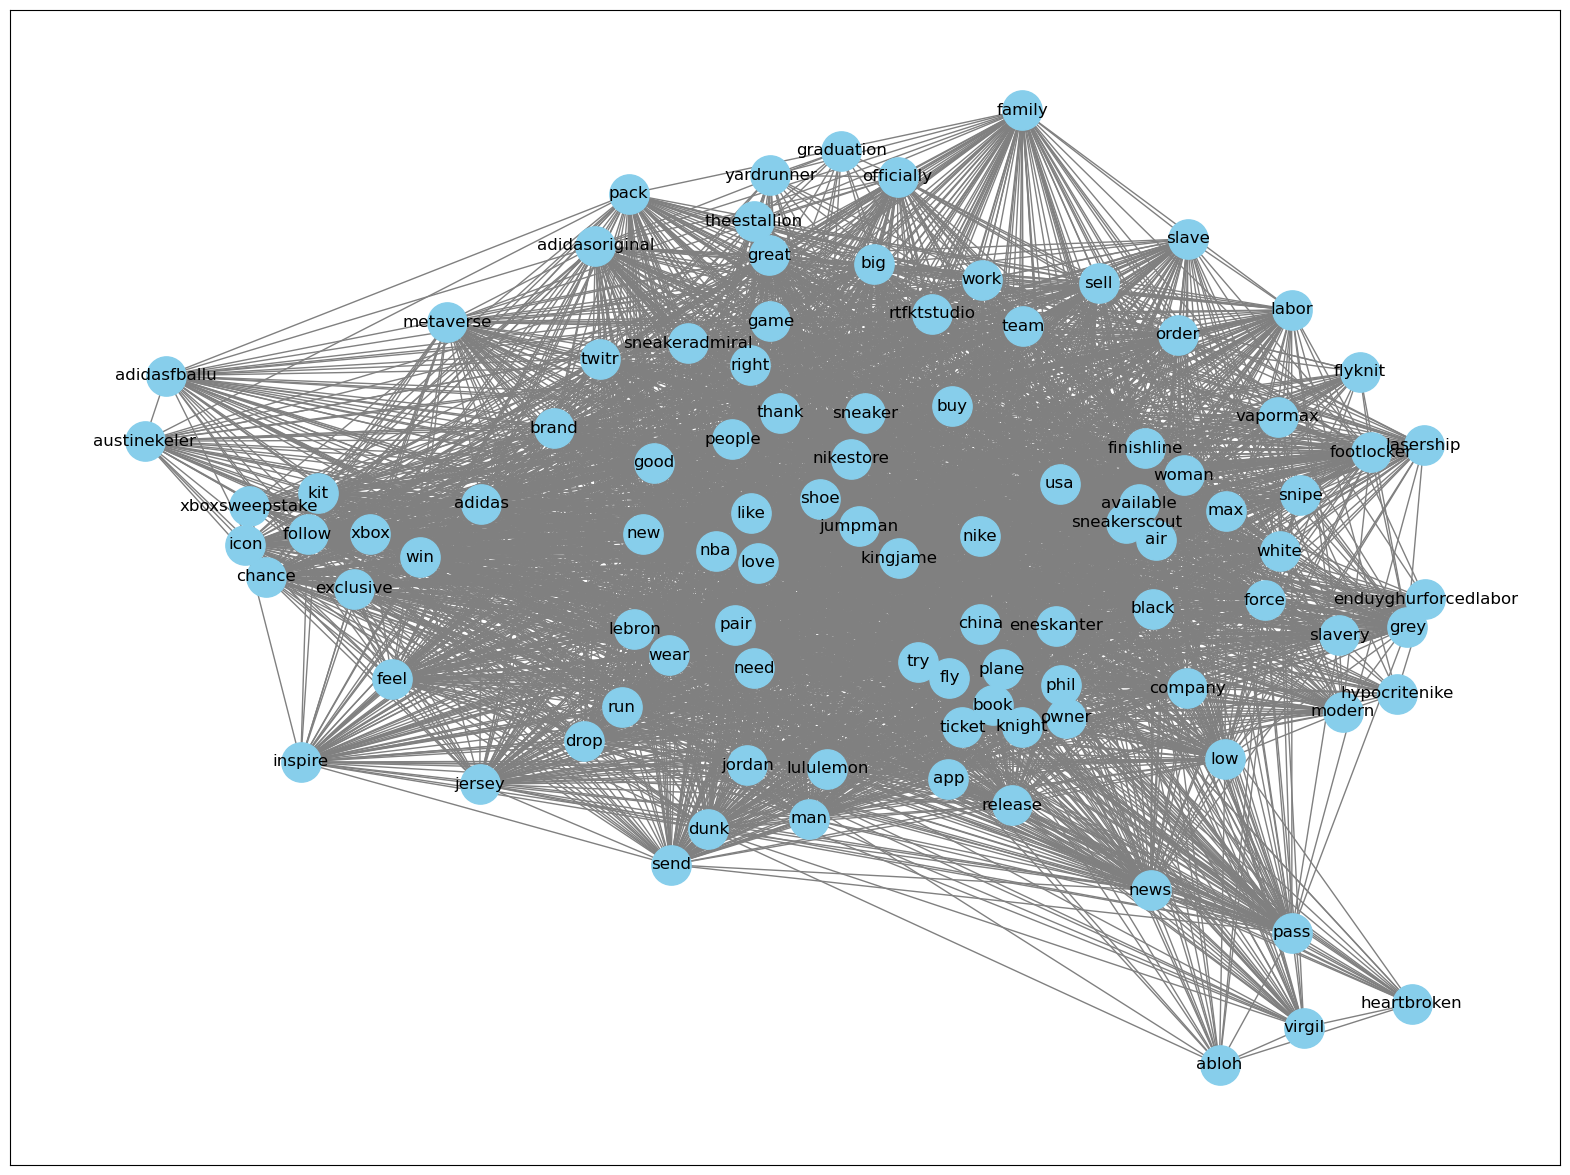

In [ ]:
draw_network_graph(graph1, figsize=(20, 15))

### Network 2
- **remove mentions**

In [ ]:
corp2 = build_corpus(tweets, sws, True)

Corpus with 163285 documents in English
> 1443819633753018400 (7 tokens): cool build dogecoin airmax shoe pay doge
> 1443823529296867300 (6 tokens): space nike lebron low available sneakerscout
> 1443818860503834600 (9 tokens): nike air vapormax evo white wolf grey available sn...
> 1443818136801849300 (4 tokens): surprise lot wait dress
> 1443820484865536000 (10 tokens): nike air vapormax evo summit white bright crimson ...
> 1443822263552389000 (9 tokens): nike air max premium deep magenta aquatone availab...
> 1443823065066922000 (2 tokens): awesome pair
> 1443823277730902000 (5 tokens): simple black white episode comethru
> 1443820600326164500 (1 tokens): good
> 1443823582702940200 (6 tokens): nike air max japan available sneakerscout
(and 163275 more documents)
total number of tokens: 817938 / vocabulary size: 2071


In [ ]:
graph2 = build_graph(corp2, 100)

['nike', 'xbox', 'available', 'sneakerscout', 'air', 'china', 'try', 'win', 'book', 'knight', 'phil', 'fly', 'owner', 'ticket', 'follow', 'plane', 'xboxsweepstake', 'chance', 'kit', 'exclusive', 'icon', 'like', 'woman', 'shoe', 'new', 'max', 'thank', 'yardrunner', 'officially', 'slavery', 'graduation', 'good', 'modern', 'enduyghurforcedlabor', 'hypocritenike', 'love', 'need', 'game', 'buy', 'pair', 'black', 'white', 'brand', 'vapormax', 'adidas', 'force', 'wear', 'right', 'sneaker', 'people', 'lebron', 'app', 'drop', 'release', 'news', 'run', 'work', 'man', 'inspire', 'great', 'company', 'team', 'metaverse', 'big', 'pass', 'flyknit', 'pack', 'labor', 'order', 'send', 'sell', 'jordan', 'grey', 'family', 'feel', 'low', 'virgil', 'dunk', 'abloh', 'slave', 'heartbroken', 'jersey', 'money', 'blazer', 'support', 'play', 'red', 'thing', 'size', 'guy', 'wait', 'generation', 'baseball', 'choose', 'congratulation', 'tell', 'store', 'world', 'stay', 'customer']
Graph has 100 nodes and 3666 edges.

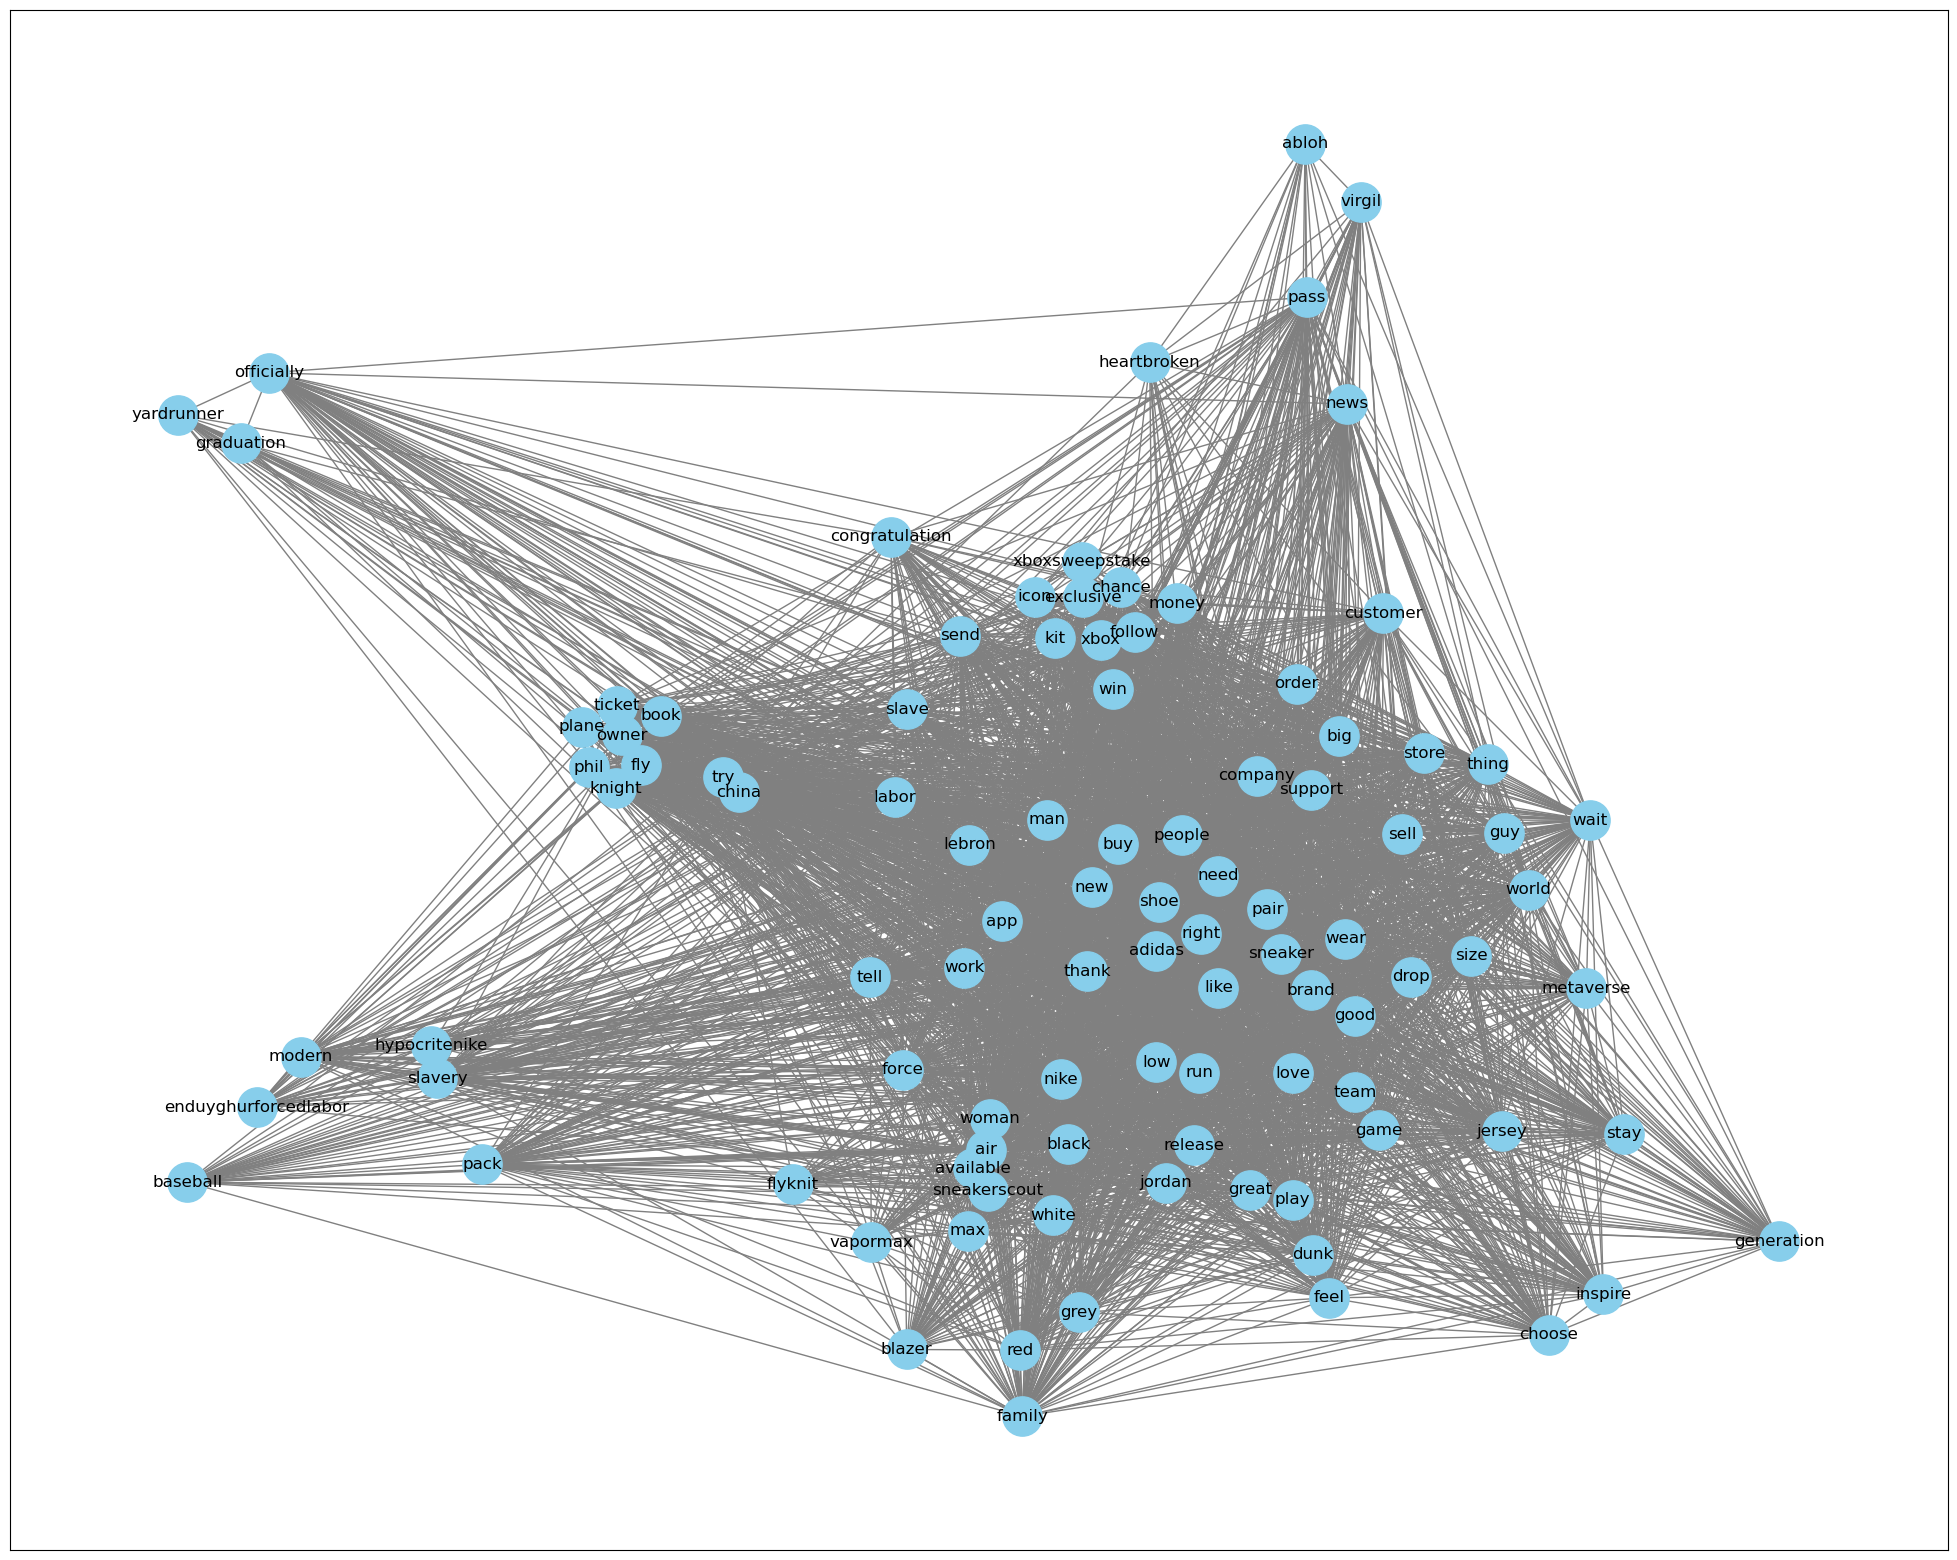

In [ ]:
draw_network_graph(graph2)

### Network 3
- **remove mentions and hashtags**

In [ ]:
corp3 = build_corpus(tweets, sws, True, True)

Corpus with 163285 documents in English
> 1443819633753018400 (7 tokens): cool build dogecoin airmax shoe pay doge
> 1443823529296867300 (6 tokens): space nike lebron low available sneakerscout
> 1443818860503834600 (9 tokens): nike air vapormax evo white wolf grey available sn...
> 1443818136801849300 (4 tokens): surprise lot wait dress
> 1443820484865536000 (10 tokens): nike air vapormax evo summit white bright crimson ...
> 1443822263552389000 (9 tokens): nike air max premium deep magenta aquatone availab...
> 1443823065066922000 (2 tokens): awesome pair
> 1443823277730902000 (5 tokens): simple black white episode comethru
> 1443820600326164500 (1 tokens): good
> 1443823582702940200 (6 tokens): nike air max japan available sneakerscout
(and 163275 more documents)
total number of tokens: 817913 / vocabulary size: 2071


In [ ]:
graph3 = build_graph(corp3, 100)

['nike', 'xbox', 'available', 'sneakerscout', 'air', 'china', 'try', 'win', 'book', 'knight', 'phil', 'fly', 'owner', 'ticket', 'follow', 'plane', 'xboxsweepstake', 'chance', 'kit', 'exclusive', 'icon', 'like', 'woman', 'shoe', 'new', 'max', 'thank', 'yardrunner', 'officially', 'slavery', 'graduation', 'good', 'modern', 'enduyghurforcedlabor', 'hypocritenike', 'love', 'need', 'game', 'buy', 'pair', 'black', 'white', 'brand', 'vapormax', 'adidas', 'force', 'wear', 'right', 'sneaker', 'people', 'lebron', 'app', 'drop', 'release', 'news', 'run', 'work', 'man', 'inspire', 'great', 'company', 'team', 'metaverse', 'big', 'pass', 'flyknit', 'pack', 'labor', 'order', 'send', 'sell', 'jordan', 'grey', 'family', 'feel', 'low', 'virgil', 'dunk', 'abloh', 'slave', 'heartbroken', 'jersey', 'money', 'blazer', 'support', 'play', 'red', 'thing', 'size', 'guy', 'wait', 'generation', 'baseball', 'choose', 'congratulation', 'tell', 'store', 'world', 'stay', 'customer']
Graph has 100 nodes and 3666 edges.

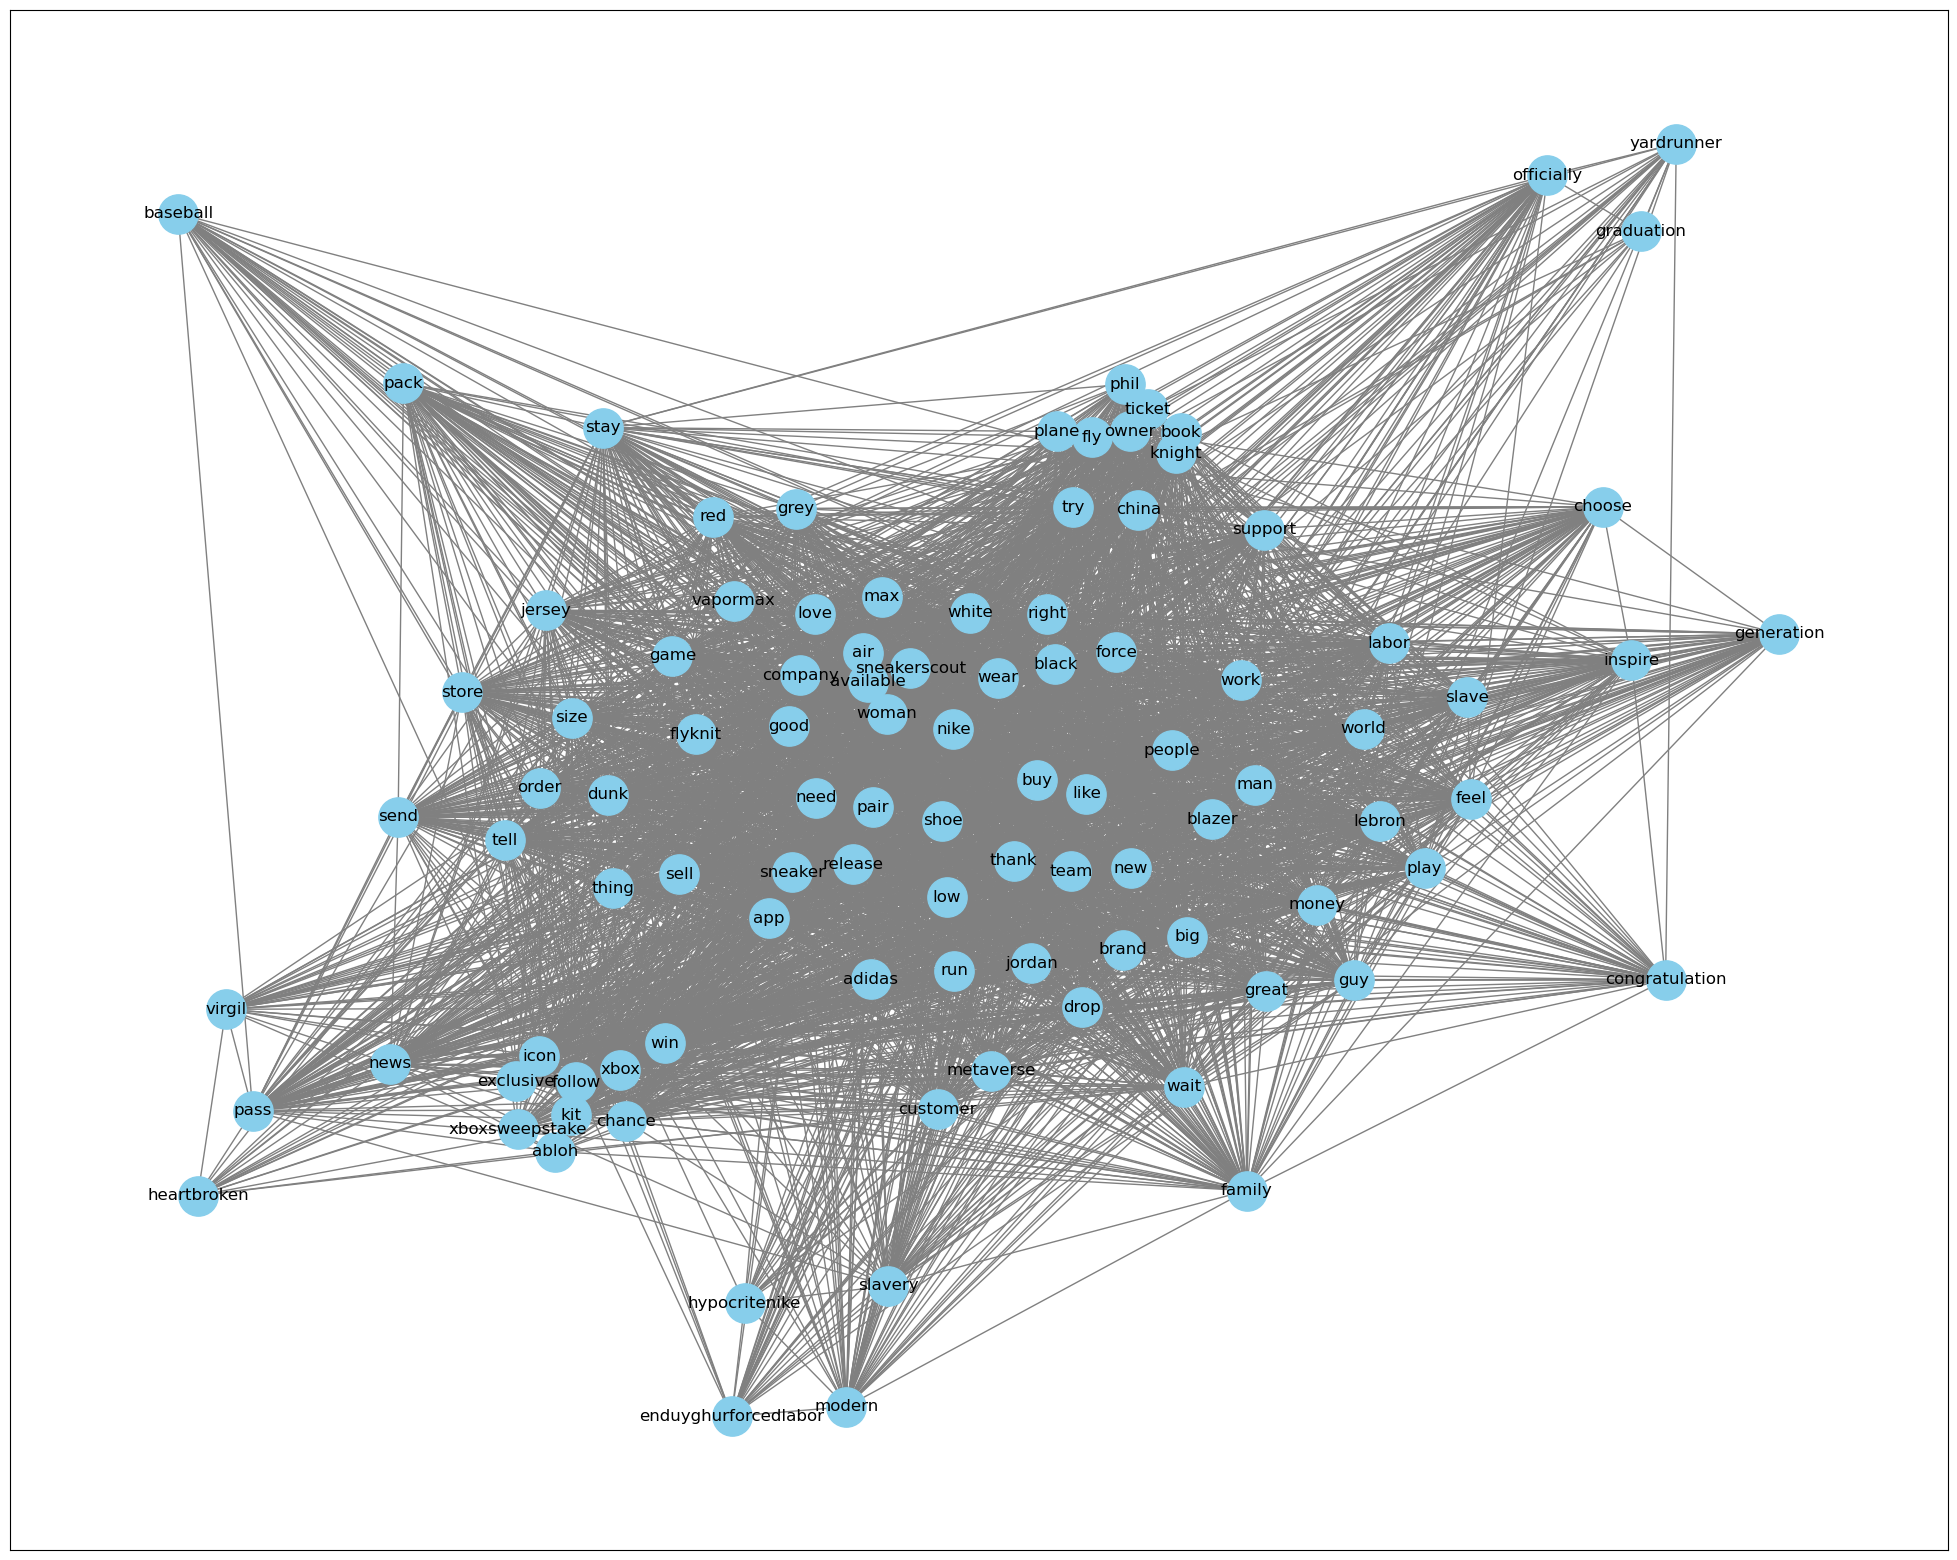

In [ ]:
draw_network_graph(graph3)

The network above plotted using tmtoolkit to process tokens, resulting in some different findings from using nltk. It can be observed that some words cluster together, representing themes mentioned in the tweets. These clusters allow us to explore what topics users are more interested in.

For example, words like "icon", "exclusive", "follow", "xboxsweepstake", "chance", and "kit" are related to events organized by brands.

Words such as "news", "virgil", "pass", and "heartbroken" seem to be related to discussions about the death of fashion designer Virgil Abloh.

Words like "phil", "knight", "plane", "ticket", and "china" are related to the issue of Uyghur forced labor. Phil Knight is the co-founder and former CEO of Nike. The terms "hypocritenike", "modern", "slavery", and "enduyghurforcedlabor" also indicate this issue. These terms show that there was significant discussion and reaction regarding this topic during the period.

There are also some clusters related to product promotion or sales.

Additionally, words like "graduation", "congratulation", "thank", "love", and "buy" indicate that consumers often discuss their fondness for these products and their use as gifts.


## Bridge Words

In [ ]:
def find_bridge_words(corpus, brands):
    brand_cooccurrence = {brand: defaultdict(int) for brand in brands}
    for doc_id in corpus.doc_labels:
        tokens = corpus[doc_id]['token']
        token_set = set(tokens)
        for brand in brands:
            if brand in token_set:
                for word in token_set:
                    if word != brand:
                        brand_cooccurrence[brand][word] += 1

    bridge_words = set.intersection(*(set(brand_cooccurrence[b].keys()) for b in brands))
    bridge_word_min_common_counts = {w: min(brand_cooccurrence[b][w] for b in brands) for w in bridge_words}
    return sorted(bridge_word_min_common_counts.items(), key=lambda x: x[1], reverse=True)
    # bridge_word_counts = {w: sum(brand_cooccurrence[b][w] for b in brands) for w in bridge_words}
    # return sorted(bridge_word_counts.items(), key=lambda x: x[1], reverse=True)


In [ ]:
bw1 = find_bridge_words(corp1, brands)
print(f'There are {len(bw1)} bridge words between {brands}')
print(f'Top 15 bridge_words: \n{bw1[:15]}')

There are 1733 bridge words between ['nike', 'adidas', 'lululemon']
Top 15 bridge_words: 
[('like', 339), ('good', 326), ('thank', 300), ('new', 262), ('work', 234), ('order', 232), ('love', 219), ('wear', 197), ('store', 196), ('need', 186), ('customer', 185), ('brand', 183), ('team', 178), ('fast', 152), ('service', 147)]


In [ ]:
bw2 = find_bridge_words(corp2, brands)
print(f'There are {len(bw2)} bridge words between {brands}')
print(f'Top 15 bridge_words: \n{bw2[:15]}')

There are 631 bridge words between ['nike', 'adidas', 'lululemon']
Top 15 bridge_words: 
[('brand', 91), ('share', 52), ('box', 50), ('new', 43), ('man', 25), ('free', 22), ('fashion', 18), ('buy', 17), ('order', 15), ('work', 15), ('young', 15), ('store', 15), ('wear', 14), ('feel', 14), ('run', 14)]


In [ ]:
bw3 = find_bridge_words(corp3, brands)
print(f'There are {len(bw3)} bridge words between {brands}')
print(f'Top 15 bridge_words: \n{bw3[:15]}')

There are 631 bridge words between ['nike', 'adidas', 'lululemon']
Top 15 bridge_words: 
[('brand', 91), ('share', 52), ('box', 50), ('new', 43), ('man', 25), ('free', 22), ('fashion', 18), ('buy', 17), ('order', 15), ('work', 15), ('young', 15), ('store', 15), ('wear', 14), ('feel', 14), ('run', 14)]
